## SARIMA on BYOML
In this notebook we will demonstrate how you can use a statistical  model like SARIMA, upload it to byoml and afterwards perform a (forecasting) prediction with the deployed model.

This uses the `custom` framework, supported by BYOML since version `1.4.0`, to use the [statsmodels](https://www.statsmodels.org) implementation of [SARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarima#statsmodels.tsa.statespace.sarimax.SARIMAX)

We use WPI data from [stata](https://www.stata-press.com/data/). See also Example 5 in [this](https://www.stata.com/manuals/tsforecastestimates.pdf) stata manual.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import httpx
import statsmodels.api as sm

from io import BytesIO

In [2]:
wpi1 = httpx.get('http://www.stata-press.com/data/r17/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
# set quarter index frequency: not necessary, but suppresses warnings
data.index.freq='QS'

data = data[['wpi']]

<AxesSubplot:xlabel='t'>

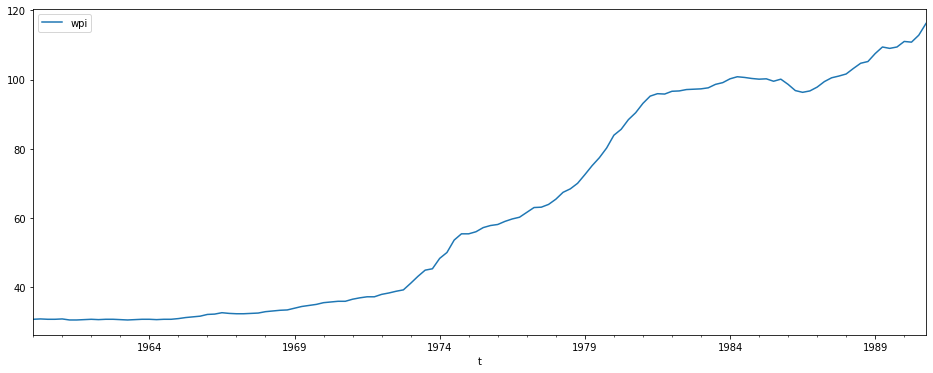

In [3]:
data.plot(figsize = (16, 6))

In [4]:
train_size = int(len(data.index) * 0.9)
df_train, df_test = data.iloc[:train_size], data.iloc[train_size:]
print(df_train.head())
print(df_test.head())

                  wpi
t                    
1960-01-01  30.700001
1960-04-01  30.799999
1960-07-01  30.700001
1960-10-01  30.700001
1961-01-01  30.799999
                   wpi
t                     
1987-10-01  101.000000
1988-01-01  101.599998
1988-04-01  103.199997
1988-07-01  104.699997
1988-10-01  105.199997


First we will create a local model, later we can compare results of the served model to this local model.

In [5]:
model = sm.tsa.SARIMAX(
    df_train,
    seasonal_order=(1, 1, 1, 4),
    order=(1, 1, 1),
)
fitted_model = model.fit(maxiter=250, disp=10)
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09970D+00    |proj g|=  2.19501D-01

At iterate   10    f=  9.82291D-01    |proj g|=  2.10097D-02

At iterate   20    f=  9.79927D-01    |proj g|=  2.44780D-03


 This problem is unconstrained.



At iterate   30    f=  9.79780D-01    |proj g|=  2.20425D-03

At iterate   40    f=  9.79774D-01    |proj g|=  2.88639D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     56      1     0     0   2.886D-05   9.798D-01
  F =  0.97977423314133616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               wpi   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -108.755
Date:                           Fri, 08 Oct 2021   AIC                            227.510
Time:                                   15:19:46   BIC                            240.827
Sample:                               01-01-1960   HQIC                           232.907
                                    - 07-01-1987                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8560      0.071     11.991      0.000       0.716       0.996
ma.L1         -0.3205      0.127     -2.530      0.011      -0.569      -0.072
ar.S.L4        0.1435      0.127      1.134      0.257      -0.105       0.391
ma.S.L4       -0.9987      4.481     -0.223      0.824      -9.781       7.784
sigma2         0.4088      1.826      0.224      0.823      -3.170       3.988
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              21.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

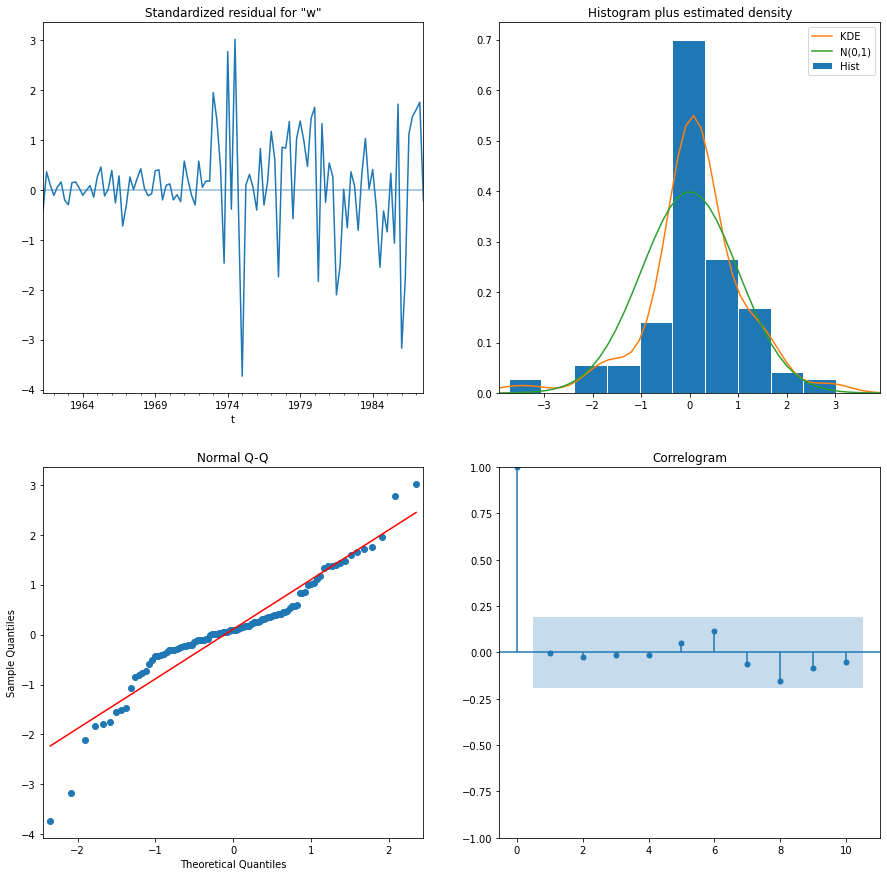

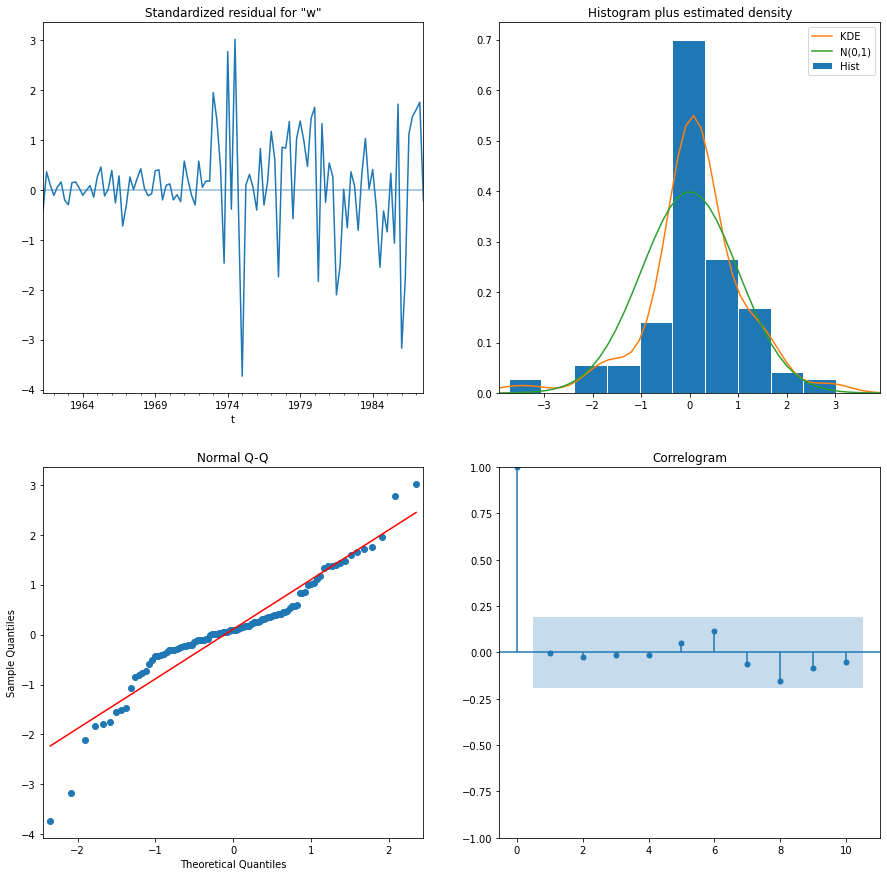

In [6]:
fitted_model.plot_diagnostics(figsize=(15, 15))

The following cell performs a one-step ahead forecast of the 30 latest data points.

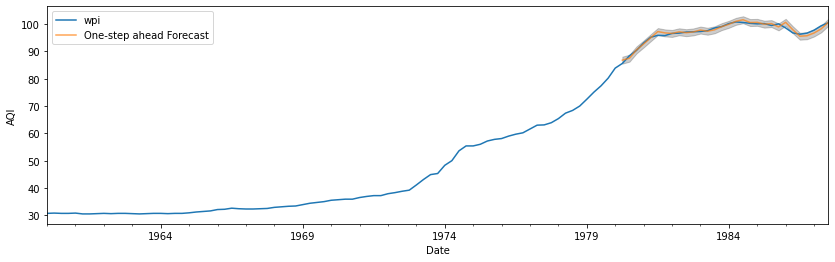

In [7]:
prediction = fitted_model.get_prediction(start=-30)
pred_ci = prediction.conf_int(alpha=0.05)
pred_mean = prediction.predicted_mean
ax = df_train.plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

The `forecast` method of the fitted model will give you predictions in the future.

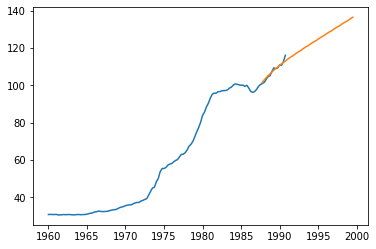

In [8]:
forecast_window = 48
forecast = fitted_model.forecast(steps=forecast_window)
plt.plot(data.index, data.wpi)
plt.plot(forecast.index, forecast.values)

The `get_forecast` method also gives confidence intervals.

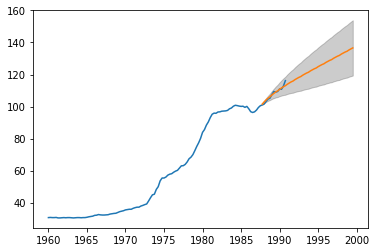

In [9]:
forecast = fitted_model.get_forecast(steps=forecast_window)
forecast_mean = forecast.predicted_mean
# using a 50% confidence interval:
forecast_ci = forecast.conf_int(alpha=0.5)
plt.plot(data.index, data.wpi)
plt.plot(forecast_mean.index, forecast_mean.values)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], 
    color='k', alpha=.2
)
plt.show()

Lets create a custom BYOML model wrapper that we can fit and deploy to BYOML.
We first set up the waylay client. 

In [10]:
from waylay import WaylayClient, RestResponseError, __version__
print(__version__)
waylay = WaylayClient.from_profile()
waylay.byoml.root_url

v0.3.0+70.g5aff33f.dirty


'https://byoml-staging.waylay.io'

We delete a model with our model name if it would already exist. 

In [11]:
MODEL_NAME = 'sarima-model'

try:
    resp = waylay.byoml.model.remove(MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-staging.waylay.io/models/sarima-model')"

We now create a helper class around the SARIMA model and test the local predict method.
* it has a `fit` method to train the model before we upload it. 
* it has a `predict` method that will be used in the deployed model to run a fitted model on an array of historical data.
* the `window` attribute defines the forecasting window used when calling `predict`.

When deployed, the `predict` function will receive only a numpy array of data, which could or could not contain timestamp data. (see `removeTimestamps` option in http://docs-io.waylay.io/#/sensors/executeQuery).
We'll assume the timestamps are included.


In [12]:
def convert_to_df(data):
    # to make the model behave the same when fitting and when deployed
    if isinstance(data, list):
        data = np.array(data)
    if isinstance(data, np.ndarray):
        (instance_count, row_count) = data.shape
        if row_count == 2:
            timestamps, values = data.transpose()                
        elif instance_count == 2:
            timestamps, values = data
        else:
            raise ValueError('This model requires a timestamp and value row as input')

        if len(timestamps) and isinstance(timestamps[0], np.number):
            # millisecond epoch is standard for waylay
            data = pd.DataFrame(values, index=pd.to_datetime(timestamps, unit='ms'))
        else:
            data = pd.DataFrame(values, index=pd.to_datetime(timestamps))

    if not isinstance(data, pd.DataFrame):
        raise ValueError('This model requires an input that can be converted to a dataframe.')
    return data

def convert_to_numpy(series_or_df):
    # convert dataframe to an array of (timestamp_millis, value) tuples
    timestamps = series_or_df.index.map(lambda _ : _.timestamp() * 1000).values
    if isinstance(series_or_df, pd.DataFrame):
        df = series_or_df
        series = [ df[c].values for c in df.columns ]
        return np.array( [ timestamps, *series ] ).transpose()
    series = series_or_df.values
    return np.array([timestamps, series]).transpose()

class SARIMAXForecaster:
    def __init__(self, window=24):
        self.window = window
        self.fitted_params = None

                
    def create_model(self, data):
        data = convert_to_df(data)   
        return sm.tsa.SARIMAX(
            data,
            seasonal_order=(1, 1, 1, 4),
            order=(1, 0, 0),
            trend=[1, 0, 0],
            enforce_stationarity=False
        )
    
    def fit(self, data, **fit_args):
        fitted_model = self.create_model(data).fit(**fit_args)
        self.fitted_params = fitted_model.params
        return fitted_model
    
    def get_fitted_model(self, data):
        model = self.create_model(data)
        if self.fitted_params is None:
            raise ValueError('Model has not been fitted')
        return model.smooth(self.fitted_params)
        
    def predict(self, data):
        fitted_model = self.get_fitted_model(data)
        df_result = fitted_model.forecast(steps=self.window)
        return  convert_to_numpy(df_result)

class SARIMAXConfidenceForecaster(SARIMAXForecaster):
    def __init__(self, window=24, alpha=0.05):
        super().__init__(window)
        self.alpha = alpha
        
    def predict(self, data):
        fitted_model = self.get_fitted_model(data)
        forecast = fitted_result.get_forecast(steps=self.window)
        df_result = fitted_result.conf_int(self.alpha)
        return convert_to_numpy(df_result)
    
class ReturnShape:
    def predict(self, data):
        return np.array(data.shape)

In [13]:
upload_model = SARIMAXForecaster()
upload_model.fit(df_train, disp=0)
preds = upload_model.predict(df_train)
preds_df = convert_to_df(preds)
preds_df

,0
1987-10-01,101.215103
1988-01-01,102.439452
1988-04-01,103.809061
1988-07-01,104.943745
1988-10-01,105.799706
1989-01-01,107.077384
1989-04-01,108.337453
1989-07-01,109.484503
1989-10-01,110.401725
1990-01-01,111.700554


In [14]:
upload_model.predict(convert_to_numpy(df_train).tolist())

/Users/thomas/opt/anaconda3/envs/byoml_sarima/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/thomas/opt/anaconda3/envs/byoml_sarima/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


array([[5.60044800e+11, 1.01215103e+02],
       [5.67993600e+11, 1.02439452e+02],
       [5.75856000e+11, 1.03809061e+02],
       [5.83718400e+11, 1.04943745e+02],
       [5.91667200e+11, 1.05799706e+02],
       [5.99616000e+11, 1.07077384e+02],
       [6.07392000e+11, 1.08337453e+02],
       [6.15254400e+11, 1.09484503e+02],
       [6.23203200e+11, 1.10401725e+02],
       [6.31152000e+11, 1.11700554e+02],
       [6.38928000e+11, 1.12907046e+02],
       [6.46790400e+11, 1.14056632e+02],
       [6.54739200e+11, 1.14998952e+02],
       [6.62688000e+11, 1.16304545e+02],
       [6.70464000e+11, 1.17483558e+02],
       [6.78326400e+11, 1.18631535e+02],
       [6.86275200e+11, 1.19582700e+02],
       [6.94224000e+11, 1.20888797e+02],
       [7.02086400e+11, 1.22052660e+02],
       [7.09948800e+11, 1.23197453e+02],
       [7.17897600e+11, 1.24150313e+02],
       [7.25846400e+11, 1.25454346e+02],
       [7.33622400e+11, 1.26609025e+02],
       [7.41484800e+11, 1.27750200e+02]])

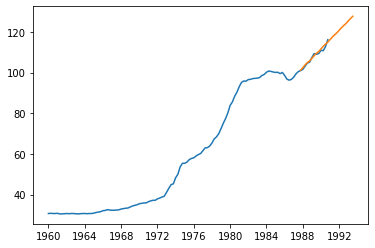

In [15]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(preds_df.index, preds_df.values)

To deploy our model on OpenFaaS, we will need to save the model using the `dill` library and upload it together with a requirements.txt file which contains the `statsmodels` library.

In [16]:
waylay.byoml.framework.get('custom')

{'default_runtime': {'framework': 'custom',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7',
  'version': '1.0'},
 'framework': 'custom'}

In [17]:
waylay.byoml.model.upload(
    MODEL_NAME,
    upload_model,
    framework='custom',
    description='SARIMA model example',
    requirements='statsmodels==0.13',
)

ByomlActionError: ByomlActionError(502: 'operation=server_error'; POST 'https://byoml-staging.waylay.io/models')

Listing the models won't affect the deployment status of the model

In [18]:
waylay.byoml.model.list(params={"name":MODEL_NAME})

[{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'createdOn': '2021-10-08T13:19:51.910000+00:00',
  'description': 'SARIMA model example',
  'framework': 'custom',
  'framework_version': '1.0',
  'metadata': {'description': 'SARIMA model example'},
  'name': 'sarima-model',
  'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'updatedOn': '2021-10-08T13:19:51.981000+00:00',
  'version': '1'}]

Getting the model, will check that the model is ready to serve ...

In [19]:
waylay.byoml.model.get(MODEL_NAME, params={"debug": True})

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-10-08T13:19:51.910000+00:00',
 'description': 'SARIMA model example',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example'},
 'name': 'sarima-model',
 'ready': False,
 'runtime': {'framework': 'custom',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7',
  'version': '1.0'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-da8781cc0d4dc5602d7c6c5a0b0b157e3592b04e.openfaas-fn-6ccc8843-d78d-49e8-84c4-3734a4af9929',
 'status': 'running',
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-10-08T13:19:51.981000+00:00',
 'version': '1'}

In [22]:
from time import time
start = time()
predictions = waylay.byoml.model.predict(MODEL_NAME, convert_to_numpy(df_train))
end = time()
display(f'took {end-start} seconds')
predictions_df = convert_to_df(predictions)
predictions_df.head

'took 71.51183104515076 seconds'

<bound method NDFrame.head of                      0
1987-10-01  101.215103
1988-01-01  102.439452
1988-04-01  103.809061
1988-07-01  104.943745
1988-10-01  105.799706
1989-01-01  107.077384
1989-04-01  108.337453
1989-07-01  109.484503
1989-10-01  110.401725
1990-01-01  111.700554
1990-04-01  112.907046
1990-07-01  114.056632
1990-10-01  114.998952
1991-01-01  116.304545
1991-04-01  117.483558
1991-07-01  118.631535
1991-10-01  119.582700
1992-01-01  120.888797
1992-04-01  122.052660
1992-07-01  123.197453
1992-10-01  124.150313
1993-01-01  125.454346
1993-04-01  126.609025
1993-07-01  127.750200>

NameError: name 'predictions_df' is not defined

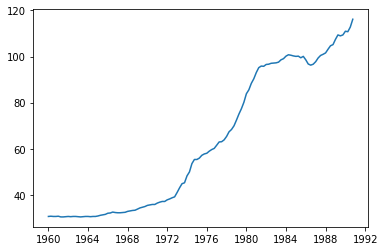

In [21]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(
    predictions_df.index,
    predictions_df.values
)

We can use the previously fitted model to change the forecast window and refit the model on the training data.

In [ ]:
resp = waylay.byoml.model.remove(MODEL_NAME)